**Notes**
- https://cloud.google.com/translate/docs/languages
- https://datahub.io/core/language-codes
- 

In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# import re
import string
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [78]:
with open('/Users/jas/ds/data/global_headlines/news-week-24aug17_langs.pkl', 'rb') as f:
    words = pickle.load(f)
    
words.rename(columns={'language':'lang_code'}, inplace=True)
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398431 entries, 0 to 1398430
Data columns (total 5 columns):
publish_time     1398431 non-null int64
feed_code        1398431 non-null object
source_url       1398431 non-null object
headline_text    1397447 non-null object
lang_code        1396962 non-null object
dtypes: int64(1), object(4)
memory usage: 53.3+ MB


In [79]:
# lang_codes = pd.read_csv('https://pkgstore.datahub.io/core/language-codes/language-codes-full_csv/data/b33b6fcda84bcbdea2da1c08587eaa65/language-codes-full_csv.csv')
# lang_codes_map = lang_codes[~lang_codes.alpha2.isnull()][['alpha2', 'English']]
# lang_codes = lang_codes_map
# lang_codes.set_index('alpha2', inplace=True)
# lang_codes_dict = lang_codes.to_dict()
# lang_codes_dict.update({'zh-CH': 'Chinese', 'zh-TW': 'Chinese-Taiwan'})
# with open('Data/lang_codes_dict.pkl', 'wb') as f:
#     pickle.dump(lang_codes_dict, f)
    
with open('Data/lang_codes_dict.pkl', 'rb') as f:
    lang_codes = pickle.load(f)
# lang_codes['English']

# Map the lang_code to the language
words['language'] = words.lang_code.map(lang_codes['English'])
words.head()

publish_time                         feed_code  \
0  201708240000                         w3-adweek   
1  201708240000                 w3-aktiencheck-de   
2  201708240000                 w3-aktiencheck-de   
3  201708240000  w3-auto-economictimes-indiatimes   
4  201708240000                     w3-azdailysun   

                                          source_url  \
0  http://www.adweek.com/digital/facebook-2017-gl...   
1  http://www.aktiencheck.de/news/Artikel-Aktien_...   
2  http://www.aktiencheck.de/news/Artikel-US_Boer...   
3  http://auto.economictimes.indiatimes.com/news/...   
4  http://azdailysun.com/sports/football/could-de...   

                                       headline_text lang_code language  
0  Here Are the Details on Facebook's Global Part...        en  English  
1  Aktien New York Schluss: Moderate Verluste nac...        de   German  
2  US-Börsen im Minus - Zittern vor Notenbankertr...        de   German  
3  Petrol & diesel on the rise post daily price r...        en  English  
4  Could DeShone Kizer end Browns' history of QB ...        en  English

### How many articles for each language?

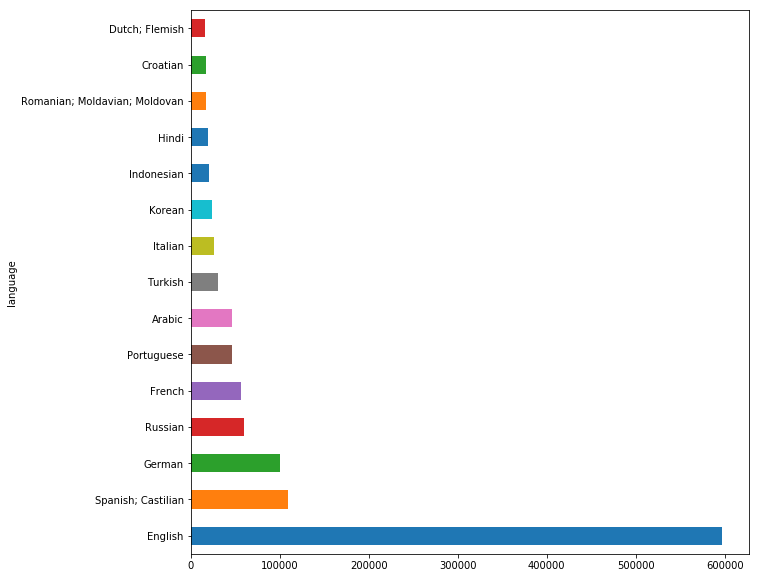

In [80]:
# View summary of top languages used
words_sum = words.groupby('language')['headline_text'].count()
words_sum.sort_values(ascending=False, inplace=True)

# This should be in a horizontal bchart
plt.figure(figsize=(10,10))
words_sum.nlargest(15).plot.barh()
# plt.show();


### Headling Pre-Processing

In [100]:
#Removes front and end punctuation, makes all lower case, removes empty strings.
def clean_news(article):    
    return ' '.join([w.lower().strip().rstrip(string.punctuation)\
        .lstrip(string.punctuation).strip()\
        for w in article.split()\
        if w.strip().rstrip(string.punctuation).strip()])

# function to force to 'None' if error in cleaning on following step
def try_clean(text):
    try:
        w = clean_news(text)
        return(w)
    except:
        return(None)

1364586 total items returned


In [103]:
# clean the headlines
words.dropna(axis=0, how='any', inplace=True)
pre_filter_1 = [try_clean(x) for x in words.headline_text]
    
print('{} total items returned'.format(len(pre_filter_1)))

# return list of indicies with 'None' values (for whatever reason) that we will drop from 'df_news'
drop_inds = [ind for ind, x in enumerate(pre_filter_1) if x is None]
        
# drop from df_news
words = words[~words.index.isin(drop_inds)]
words['prepped_headlines'] = pre_filter_1

words.sample(10)

1364586 total items returned


In [106]:
words.sample(5)

publish_time              feed_code  \
161964   201708241646           w3-4-traders   
1321197  201708301301  w3-statoquotidiano-it   
807836   201708280803       w3-hinduismtoday   
34734    201708240401         w3-biz-heraldm   
1363973  201708302012                w3-koha   

                                                source_url  \
161964   http://www.4-traders.com/GRUPO-AVAL-ACCIONES-Y...   
1321197  http://www.statoquotidiano.it/30/08/2017/basta...   
807836   http://www.hinduismtoday.com/blogs-news/hindu-...   
34734    http://biz.heraldcorp.com/view.php?ud=20170824...   
1363973  http://www.koha.net/sport/41191/ambasadorja-e-...   

                                             headline_text lang_code  \
161964   Grupo Aval Acciones y Valores : Notices publis...        es   
1321197  &#8220;Basta con la politica dell&#8217;odio, ...        it   
807836   Vinayaka Chavithi Celebrated with Great Zeal i...        en   
34734                               인천시, 신규 공무원 302명 추가 채용        ko   
1363973  Ambasadorja e Kosovës në Hungari ndaj medaljet...        sq   

                   language                                  prepped_headlines  
161964   Spanish; Castilian  grupo aval acciones y valores notices publishe...  
1321197             Italian  8220;basta con la politica dell&#8217;odio la ...  
807836              English  vinayaka chavithi celebrated with great zeal i...  
34734                Korean                              인천시 신규 공무원 302명 추가 채용  
1363973            Albanian  ambasadorja e kosovës në hungari ndaj medaljet...

### Word Clouds for Fun

In [112]:
words[words.language == 'Spanish; Castilian']['prepped_headlines']

108806

/Users/jas/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


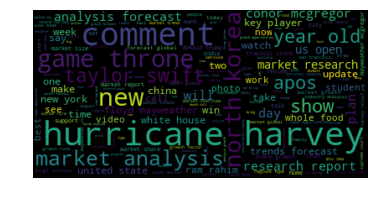

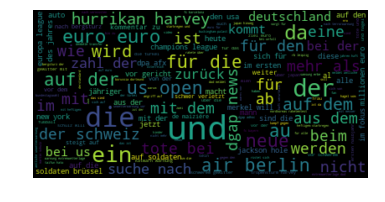

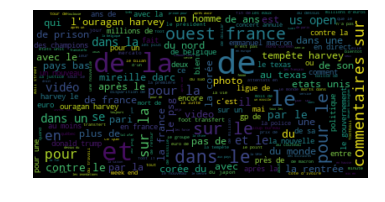

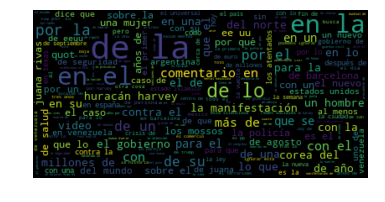

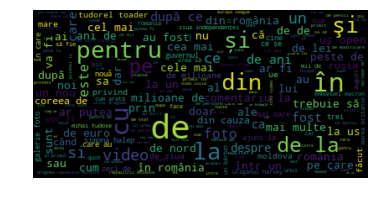

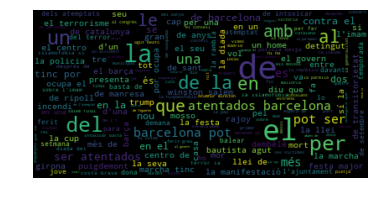

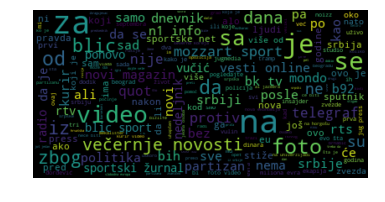

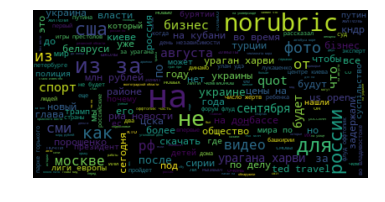

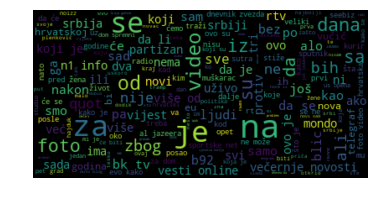

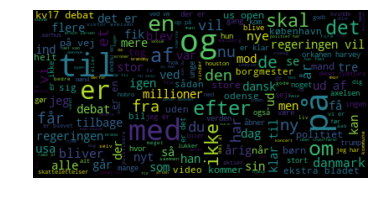

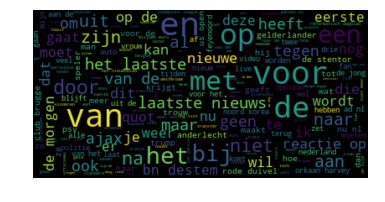

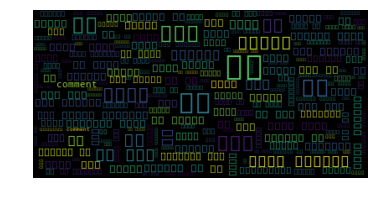

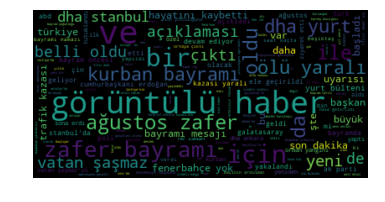

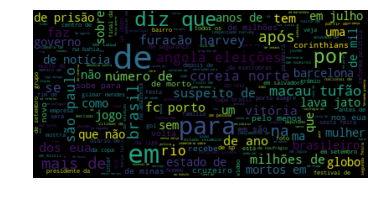

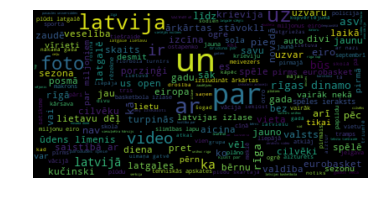

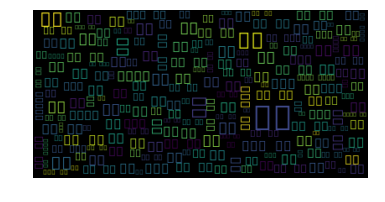

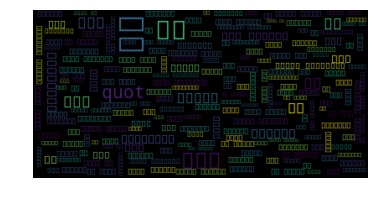

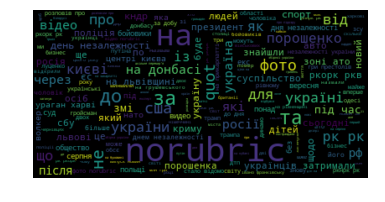

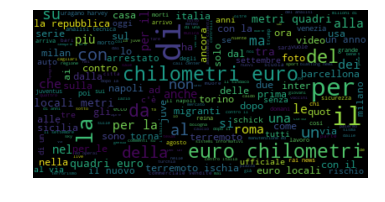

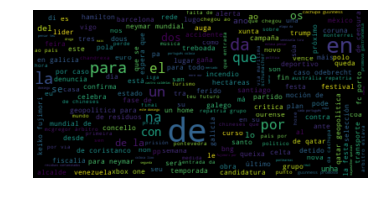

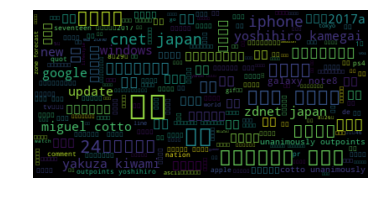

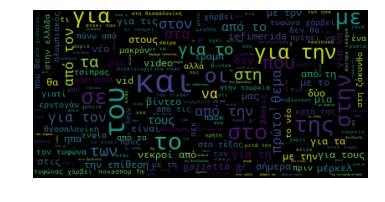

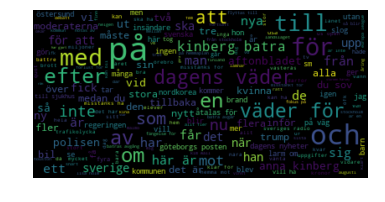

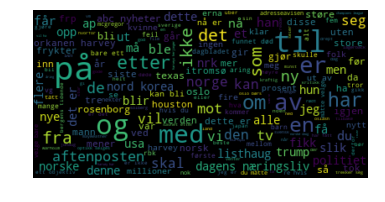

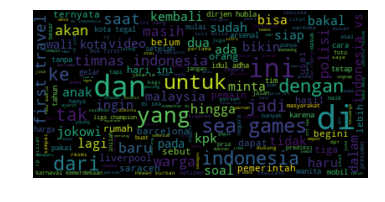

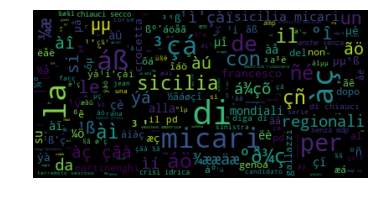

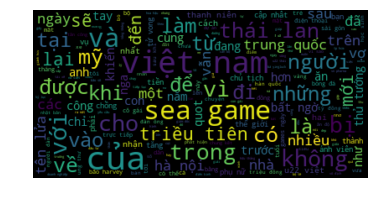

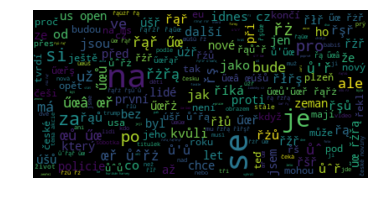

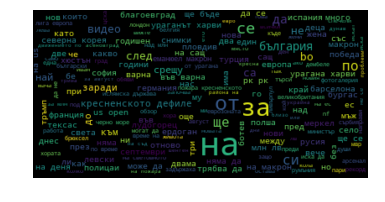

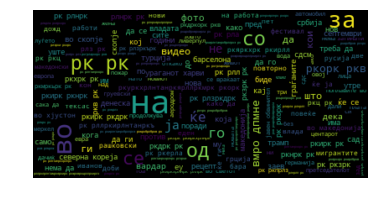

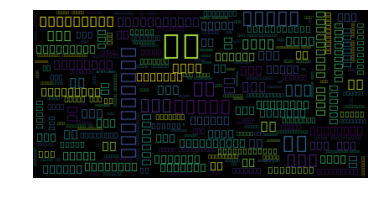

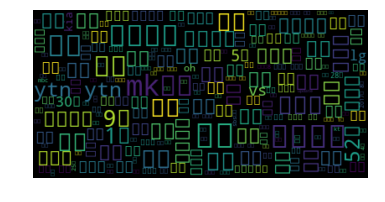

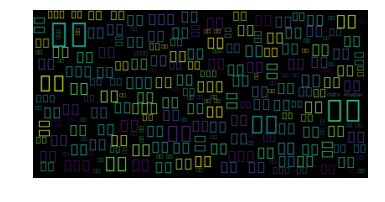

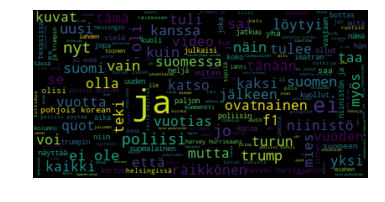

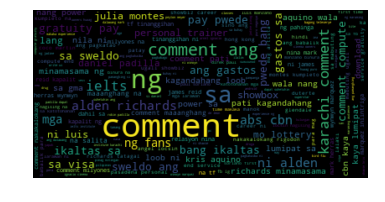

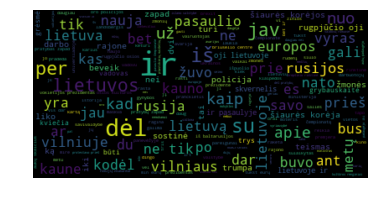

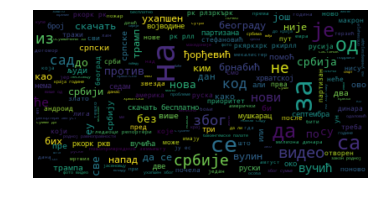

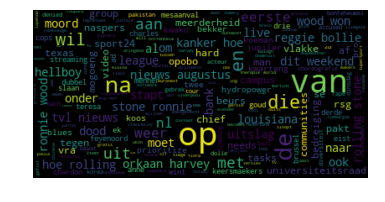

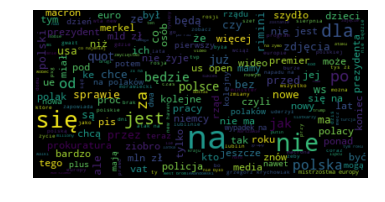

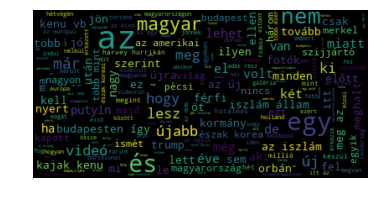

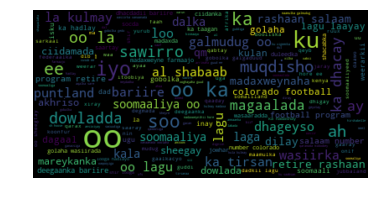

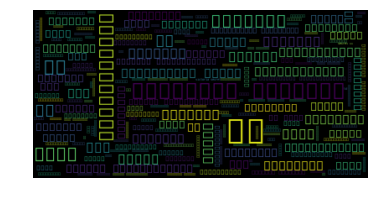

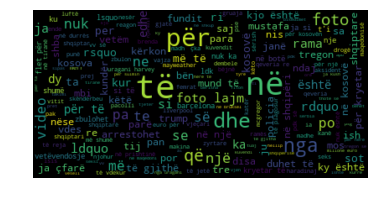

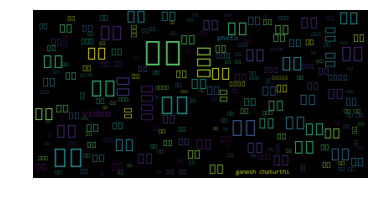

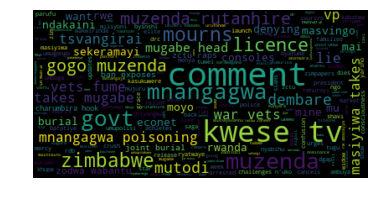

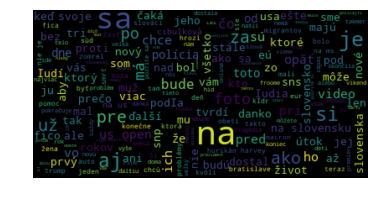

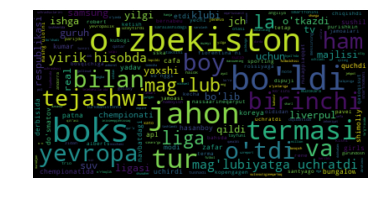

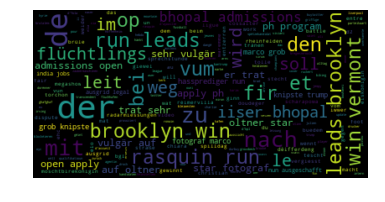

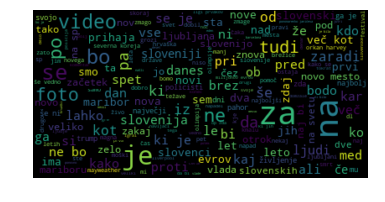

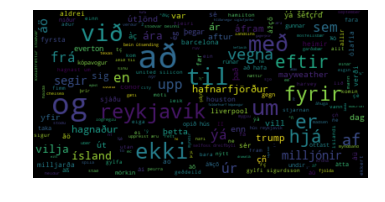

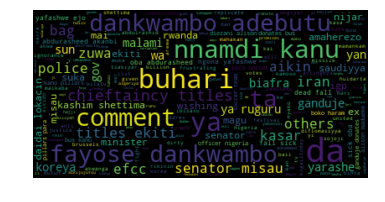

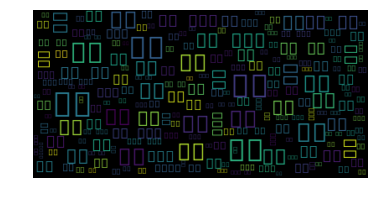

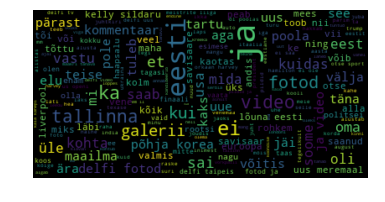

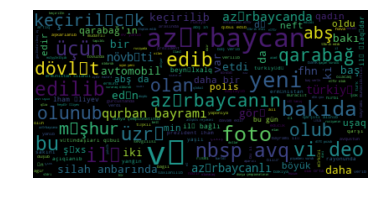

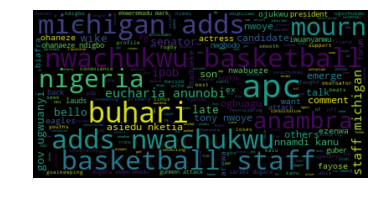

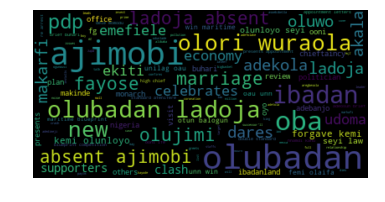

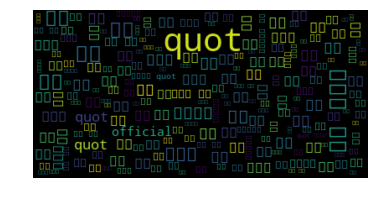

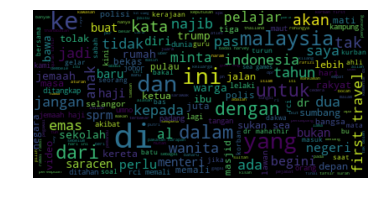

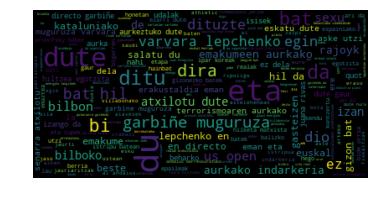

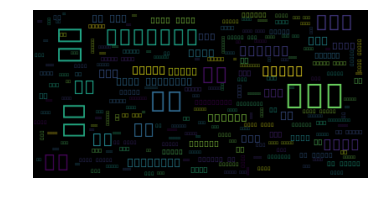

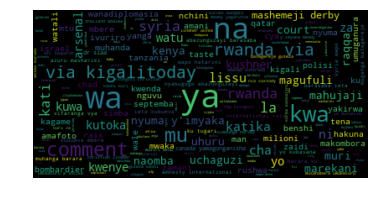

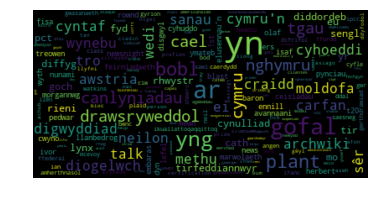

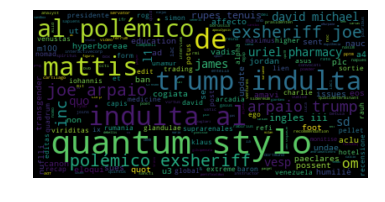

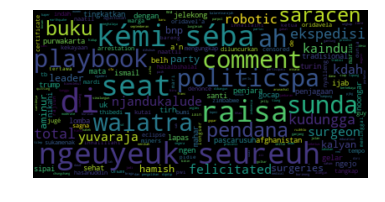

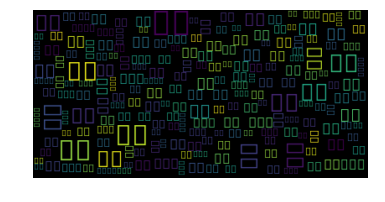

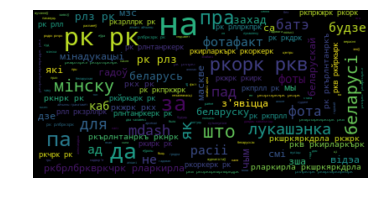

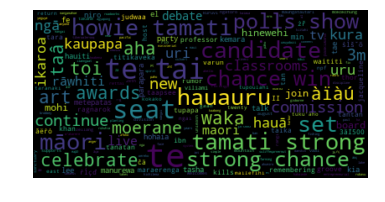

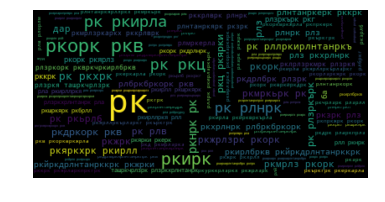

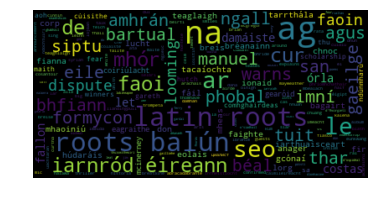

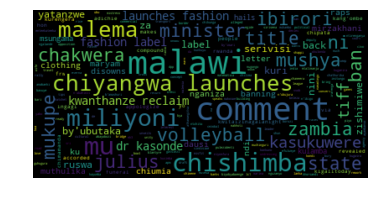

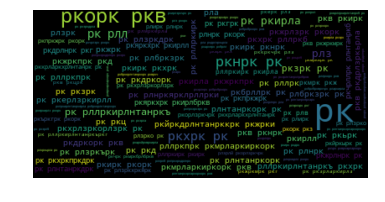

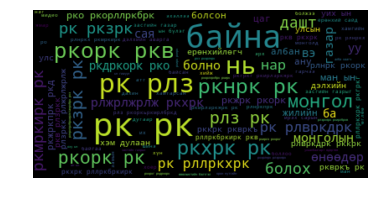

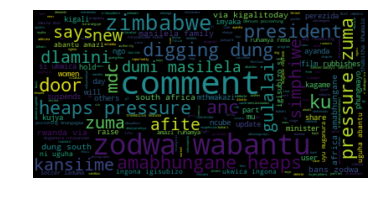

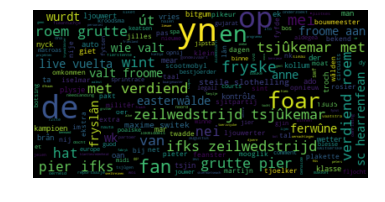

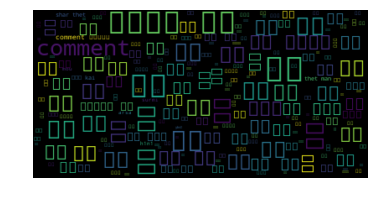

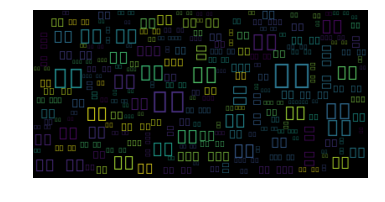

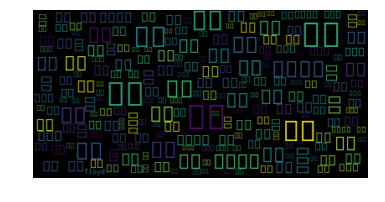

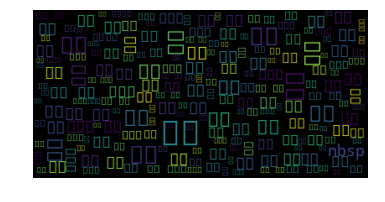

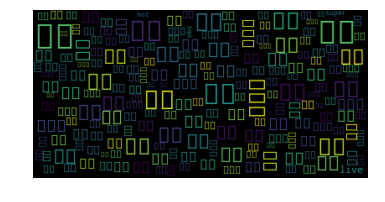

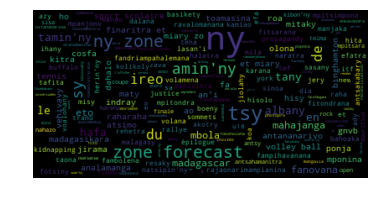

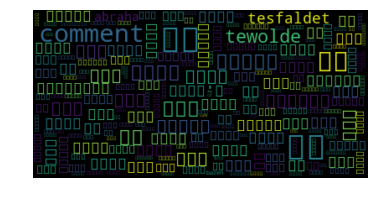

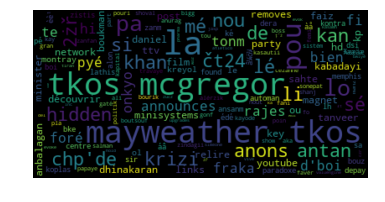

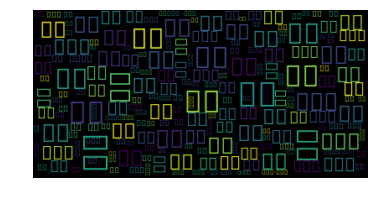

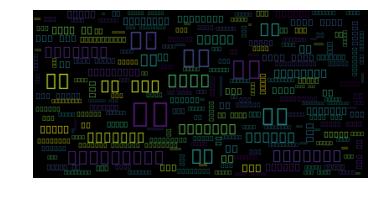

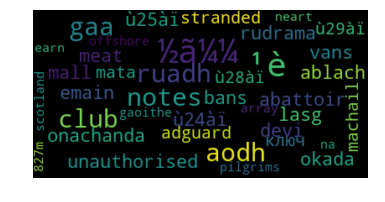

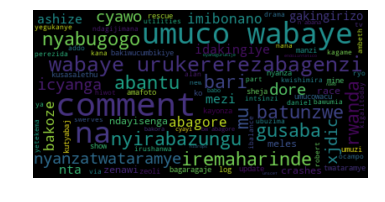

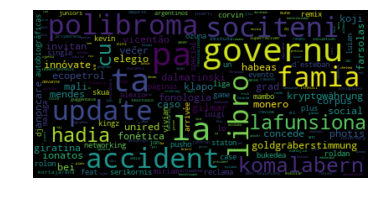

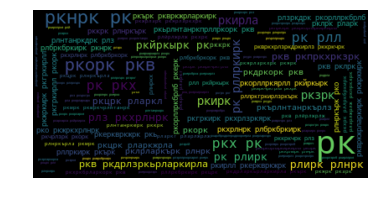

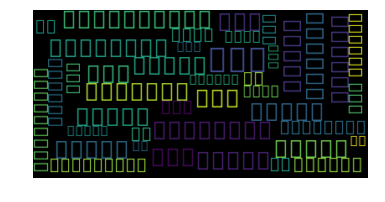

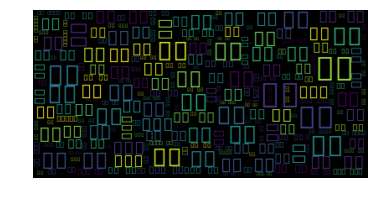

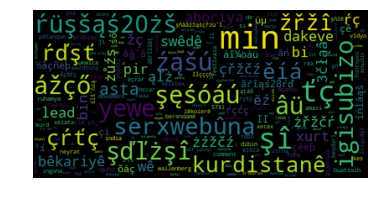

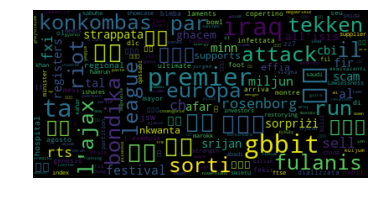

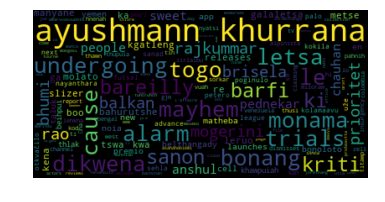

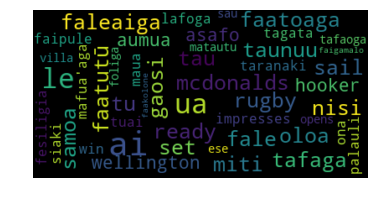

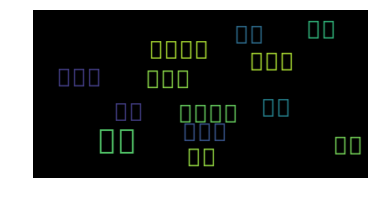

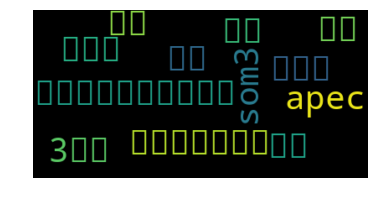

In [114]:
from wordcloud import WordCloud
# total headlines into wordcloud


# language based headlines into wordcloud
for language in words.language.unique():
    # Read the whole text.
    # text = open(path.join(d, 'constitution.txt')).read()
    text = ' '.join(words[words.language == language]['prepped_headlines'])

    # # Generate a word cloud image
    # wordcloud = WordCloud().generate(text)

    # # Display the generated image:
    # # the matplotlib way:
    # plt.imshow(wordcloud, interpolation='bilinear')
    # plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # plt.savefig('Visuals/twitter_cloud.png', dpi=900, bbox_inches='tight'); # , bbox_inches='tight'
    # plt.show()

In [ ]:
# from os import path
from wordcloud import WordCloud

# d = path.dirname(__file__)

# Read the whole text.
# text = open(path.join(d, 'constitution.txt')).read()
text = ' '.join(clean_list)

# # Generate a word cloud image
# wordcloud = WordCloud().generate(text)

# # Display the generated image:
# # the matplotlib way:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.savefig('Visuals/twitter_cloud.png', dpi=900, bbox_inches='tight'); # , bbox_inches='tight'
# plt.show()

### Word Frequency, by language

In [141]:
from collections import Counter
import operator

word_count_by_lang = []
for language in words.language.unique():
    # Isolate the headlines per language
    temp_token_words = [word_tokenize(word) for word in words[words.language == language]['prepped_headlines']]
    
    # Create a master list of all words in headlines of that language
    temp_word_master = []
    for word in temp_token_words:
        temp_word_master.extend(word)
    
    # Create a counter of the words
    word_counter = Counter(temp_word_master)
    sorted_counter = sorted(word_counter.items(), key=operator.itemgetter(1))
    word_count_by_lang.append(sorted_counter)
    print('{} analysis completed'.format(language))

English analysis completed
German analysis completed
French analysis completed
Spanish; Castilian analysis completed
Romanian; Moldavian; Moldovan analysis completed
Catalan; Valencian analysis completed
Bosnian analysis completed
Russian analysis completed
Croatian analysis completed
Danish analysis completed
Dutch; Flemish analysis completed
Persian analysis completed
Turkish analysis completed
Portuguese analysis completed
Latvian analysis completed
Tamil analysis completed
Arabic analysis completed
Ukrainian analysis completed
Italian analysis completed
Galician analysis completed
Japanese analysis completed
Greek, Modern (1453-) analysis completed
Swedish analysis completed
Norwegian analysis completed
Indonesian analysis completed
Corsican analysis completed
Vietnamese analysis completed
Czech analysis completed
Bulgarian analysis completed
Macedonian analysis completed
Armenian analysis completed
Korean analysis completed
Hindi analysis completed
Finnish analysis completed
Tagal

In [148]:
sorted_counter

[('ມື້ເຮັດວຽກທຳອິດຂອງກອງປະຊຸມຄັ້ງທີ3ເຈົ້າຫນ້າທີ່ອາວຸໂສ', 1),
 ('apec', 1),
 ('som3', 1)]

In [142]:
# with open('Data/language_word_counts.pkl', 'wb') as f:
#     pickle.dump(word_count_by_lang, f)

with open('Data/language_word_counts.pkl', 'rb') as f:
    word_count_by_lang = pickle.load(f)

In [147]:
word_count_by_lang[:2]
#     top_pairs = {k: x[k] for k in list(x)[:20]}
#     print(top_pairs)

[[('weyant', 1),
  ('chisebwe', 1),
  ('zambia-machina', 1),
  ('rhythmone', 1),
  ('refactoring', 1),
  ('auto-renewable', 1),
  ('irving-klay', 1),
  ('imthedudedude', 1),
  ('breslin', 1),
  ('seaanuineill', 1),
  ('h.l', 1),
  ('bhambri', 1),
  ('gunneswaran', 1),
  ('shrouding', 1),
  ('grizzled', 1),
  ('hoplite', 1),
  ('17,320', 1),
  ('malwaretech', 1),
  ('reeva', 1),
  ('anti-pollution', 1),
  ('whiteside™', 1),
  ('donw', 1),
  ('protalex', 1),
  ('36.94', 1),
  ('81.76', 1),
  ('25.27', 1),
  ('90.64', 1),
  ('law-office', 1),
  ('bandoleer', 1),
  ('clippy', 1),
  ('spot-stealers', 1),
  ('barkat', 1),
  ('boehlert/shareblue', 1),
  ('msujaws', 1),
  ('usaa', 1),
  ('coattails', 1),
  ('±â¾æâ÷', 1),
  ('½ºæ÷æ¼áö', 1),
  ("ú¸äá¼³æã'ç", 1),
  ('¼±á¤', 1),
  ("àì'óàûàî", 1),
  ('â÷', 1),
  ('ìçô', 1),
  ('tormdk', 1),
  ('antongranis', 1),
  ('extinctions', 1),
  ('cybernetics', 1),
  ('lono', 1),
  ('bypasses', 1),
  ('mid-wilshire', 1),
  ('prospering', 1),
  ('narita', 1)

In [140]:
words[words.language == 'English']['prepped_headlines']

0          here are the details on facebook's global part...
3          petrol diesel on the rise post daily price rev...
4          could deshone kizer end browns history of qb m...
5          comment on microsoft will never again sneakily...
6          comment on what is google chrome enterprise by...
7              lakeland college dairy centre officially open
9          the new uncharted is the best 40 you can spend...
11                         why espn and robert lee are right
12         louise linton's famous post and instagram's ce...
14         broomfield council sets oil gas ballot item th...
15         fec meeting must not be held every week presid...
16         pick igbo man as new sgf apc chieftain udeogar...
20         fake importers smuggle 22 billion through algi...
31         u.s trump threatens government closure to achi...
32             how to pre-order xbox one x's scorpio edition
33                            home purchases down 12 percent
34         romania propo

### Topic Modeling for Each Language

In [ ]:
# only basic term frequency can be considered with LDA because it defines 
# its own PROBABALISTIC determination of topics / grouping / etc.

n_components = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=3,
                                ngram_range=(1,3),
                                max_features=1000,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(clean_list)

# define model (lda) and model parameters, fit model to vectorized data
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)
lda.fit(tf)

vocab = tf_vectorizer.get_feature_names()

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx), " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#         print (" ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vocab, n_components)